In [1]:
# 2-dimensional heat equation
# u_t = c^2 * (u_xx + u_yy)
# u(0,y,t) = u(a,y,t) = 0   0<=y<=b, t>=0
# u(x,0,t) = u(x,b,t) = 0   0<=x<=a, t>=0
# u(x,y,0) = f(x,y)

import numpy as np
import matplotlib.pyplot as plt
import nangs
import torch

from nangs import *

device = "cuda" if torch.cuda.is_available() else "cpu"

class Heat(PDE):
    def computePDELoss(self, inputs, outputs):
        
        x, y, t=inputs[:,0], inputs[:,1], inputs[:,2]
        u = outputs[:,0]
        
        #compute gradients
        grads=self.computeGrads(outputs, inputs)
        
        #compute loss
        u_x, u_y, u_t=grads[:, 0], grads[:, 1], grads[:, 2]
        
        grads2=self.computeGrads(u_x, inputs)
        u_xx=grads2[:, 0]
        
        grads2=self.computeGrads(u_y, inputs)
        u_yy=grads2[:, 1]
        
        # c = 1, a = 1, b = 1
        return {'pde': u_t-u_xx-u_yy}
    
pde=Heat(inputs=('x', 'y', 't'), outputs='u')

In [2]:
# a = b = 1

x = np.linspace(0,1,20)
y = np.linspace(0,1,20)
t = np.linspace(0,1,30)

mesh = Mesh({'x': x, 'y': y, 't': t}, device=device)
pde.set_mesh(mesh)

In [3]:
# boundary conditions

x0 = np.array([0., 1.])
y0 = np.array([0., 1.])
t0 = np.array([0])

_x, _y, _t = np.meshgrid(x, y, t0)
u0 = np.sin(np.pi*_x)*np.sin(np.pi*_y)
initial_condition=Dirichlet({'x': x, 'y': y, 't': t0}, {'u': u0.reshape(-1)}, 
                            device=device, name='initial')
pde.add_boco(initial_condition)

_x, _y, _t = np.meshgrid(x0, y, t)
u1 = _x*_y*_t*0
boco_x=Dirichlet({'x': x0, 'y': y, 't': t}, {'u': u1.reshape(-1)}, device=device, 
                 name='boco_x')
pde.add_boco(boco_x)

_x, _y, _t = np.meshgrid(x, y0, t)
u1 = _x*_y*_t*0
boco_y=Dirichlet({'x': x, 'y': y0, 't': t}, {'u': u1.reshape(-1)}, device=device, 
                 name='boco_y')
pde.add_boco(boco_y)

In [4]:
BATCH_SIZE = 512
LR = 5e-4
EPOCHS = 1000
NUM_LAYERS = 8
NUM_HIDDEN = 256

mlp = MLP(len(pde.inputs), len(pde.outputs), NUM_LAYERS, NUM_HIDDEN).to(device)
optimizer = torch.optim.Adam(mlp.parameters())
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, 
                                                pct_start=0.1, total_steps=EPOCHS)

pde.compile(mlp, optimizer, scheduler)
%time hist = pde.solve(EPOCHS, BATCH_SIZE)

Wall time: 2h 31min 46s


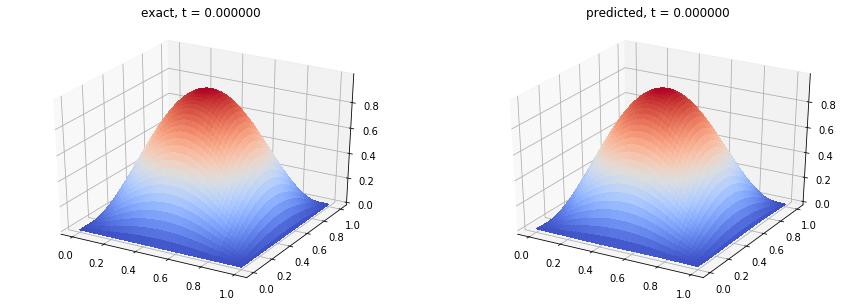

L2 error:  0.18754198000447964


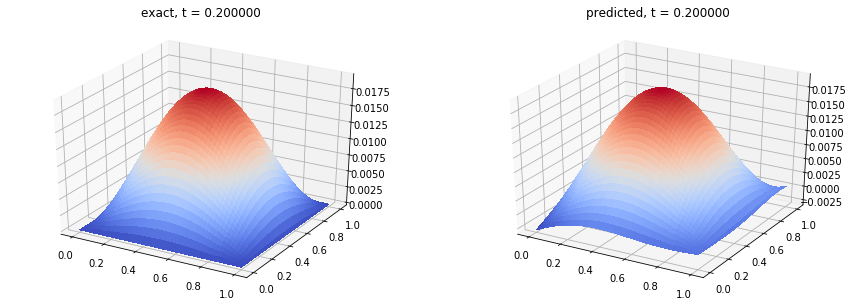

L2 error:  0.05607496258679293


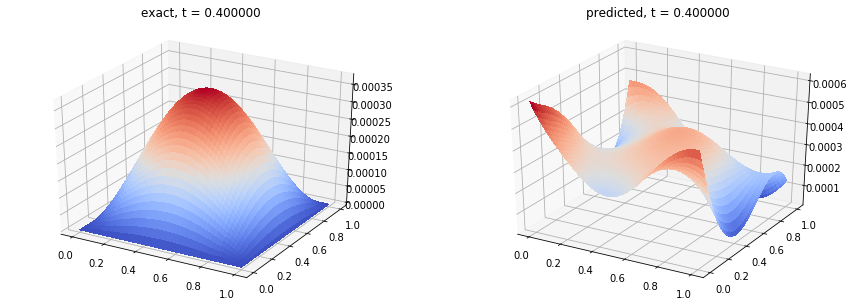

L2 error:  0.02078286296332507


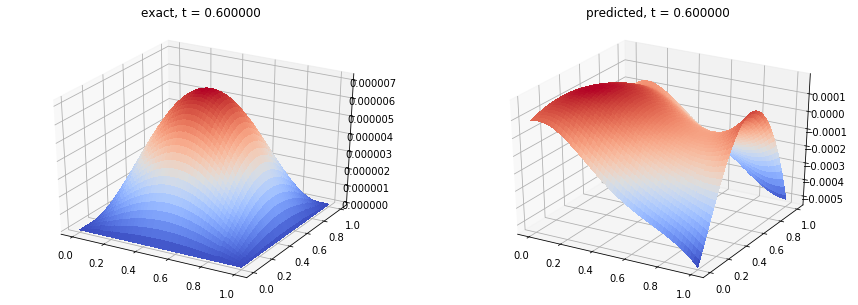

L2 error:  0.014658205248311754


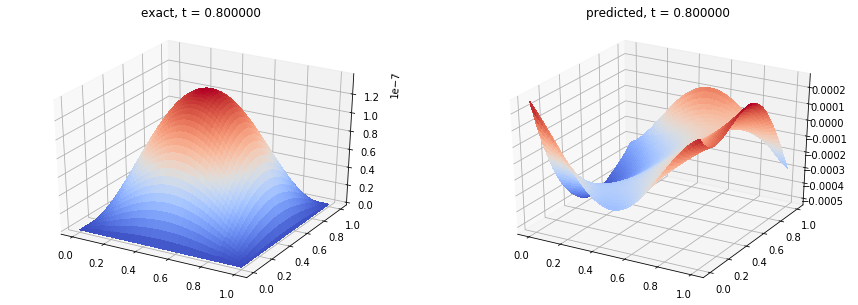

L2 error:  0.02243865328570903


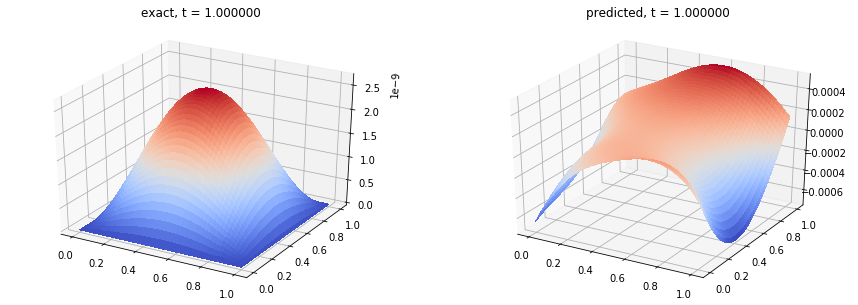

L2 error:  0.023176498243226498


In [7]:
# evaluate
from mpl_toolkits.mplot3d import Axes3D

x = np.linspace(0,1,100)
y = np.linspace(0,1,100)
t = np.array([0,0.2,0.4,0.6,0.8,1])

for t1 in t:

    eval_mesh=Mesh({'x': x,'y': y, 't':t1}, device=device)

    u=pde.eval(eval_mesh)
    u=u.cpu().numpy()
    
    _x, _y=np.meshgrid(x,y)
    u0=np.sin(np.pi*_x)*np.sin(np.pi*_y)*(np.exp(-2*np.pi*np.pi*t1))

    fig=plt.figure(figsize=(15, 5))
    ax1=fig.add_subplot(1,2,1,projection='3d')
    ax2=fig.add_subplot(1,2,2,projection='3d')
    ax1.plot_surface(_x, _y, u0.reshape((len(_y),len(_x))), cmap=cm.coolwarm, 
                     linewidth=0, antialiased=False)
    ax1.title.set_text('exact, t = %f' % t1)
    ax2.plot_surface(_x, _y, u.reshape((len(_y),len(_x))), cmap=cm.coolwarm, 
                     linewidth=0, antialiased=False)
    ax2.title.set_text('predicted, t = %f' % t1)
    plt.show()
    print("L2 error: ", np.sqrt(sum((u0.ravel()-u.ravel())**2)))

In [2]:
# 2-dimensional heat equation
# u_t = c^2 * (u_xx + u_yy)
# u(0,y,t) = u(a,y,t) = 0   0<=y<=b, t>=0
# u(x,0,t) = u(x,b,t) = 0   0<=x<=a, t>=0
# u(x,y,0) = f(x,y)

import numpy as np
import matplotlib.pyplot as plt
import nangs
import torch

from nangs import *

device = "cuda" if torch.cuda.is_available() else "cpu"

class Heat(PDE):
    def computePDELoss(self, inputs, outputs):
        
        x, y, t=inputs[:,0], inputs[:,1], inputs[:,2]
        u = outputs[:,0]
        
        #compute gradients
        grads=self.computeGrads(outputs, inputs)
        
        #compute loss
        u_x, u_y, u_t=grads[:, 0], grads[:, 1], grads[:, 2]
        
        grads2=self.computeGrads(u_x, inputs)
        u_xx=grads2[:, 0]
        
        grads2=self.computeGrads(u_y, inputs)
        u_yy=grads2[:, 1]
        
        # c = 0.1, a = 1, b = 1
        return {'pde': u_t-0.01*u_xx-0.01*u_yy}
    
pde=Heat(inputs=('x', 'y', 't'), outputs='u')

In [3]:
# a = b = 1

x = np.linspace(0,1,20)
y = np.linspace(0,1,20)
t = np.linspace(0,1,30)

mesh = Mesh({'x': x, 'y': y, 't': t}, device=device)
pde.set_mesh(mesh)

In [4]:
# boundary conditions

x0 = np.array([0., 1.])
y0 = np.array([0., 1.])
t0 = np.array([0])

_x, _y, _t = np.meshgrid(x, y, t0)
u0 = np.sin(np.pi*_x)*np.sin(np.pi*_y)
initial_condition=Dirichlet({'x': x, 'y': y, 't': t0}, {'u': u0.reshape(-1)}, 
                            device=device, name='initial')
pde.add_boco(initial_condition)

_x, _y, _t = np.meshgrid(x0, y, t)
u1 = _x*_y*_t*0
boco_x=Dirichlet({'x': x0, 'y': y, 't': t}, {'u': u1.reshape(-1)}, device=device, 
                 name='boco_x')
pde.add_boco(boco_x)

_x, _y, _t = np.meshgrid(x, y0, t)
u1 = _x*_y*_t*0
boco_y=Dirichlet({'x': x, 'y': y0, 't': t}, {'u': u1.reshape(-1)}, device=device, 
                 name='boco_y')
pde.add_boco(boco_y)

In [5]:
BATCH_SIZE = 512
LR = 5e-4
EPOCHS = 1000
NUM_LAYERS = 8
NUM_HIDDEN = 256

mlp = MLP(len(pde.inputs), len(pde.outputs), NUM_LAYERS, NUM_HIDDEN).to(device)
optimizer = torch.optim.Adam(mlp.parameters())
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, 
                                                pct_start=0.1, total_steps=EPOCHS)

pde.compile(mlp, optimizer, scheduler)
%time hist = pde.solve(EPOCHS, BATCH_SIZE)

Wall time: 3h 8min 38s


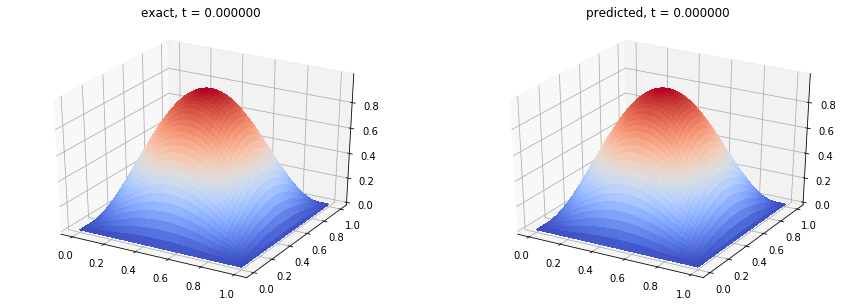

L2 error:  0.0666568777406952


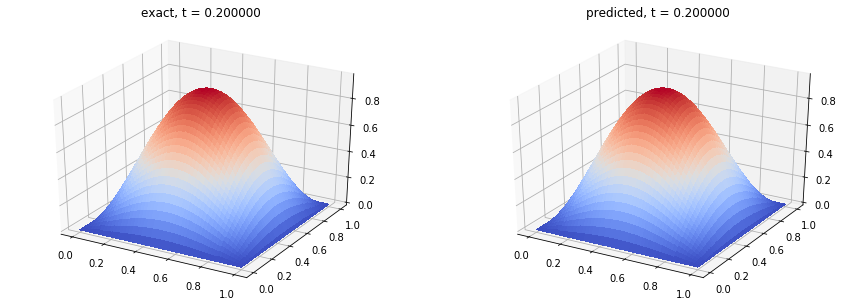

L2 error:  0.05659373945783522


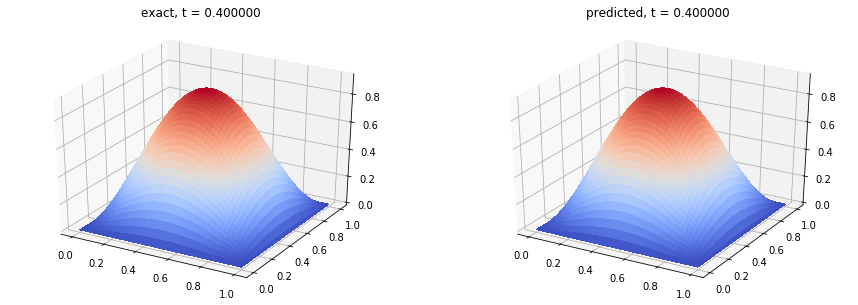

L2 error:  0.050743190514850586


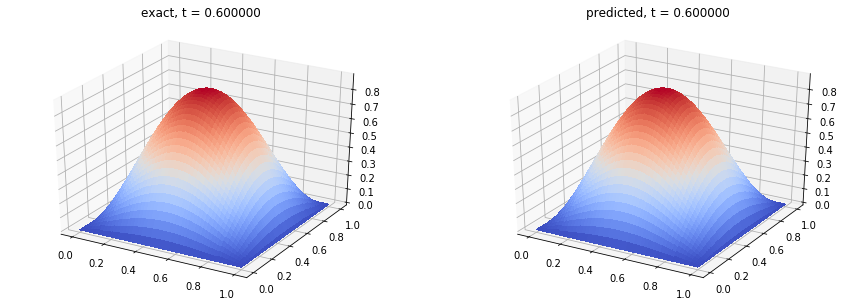

L2 error:  0.043165185631172866


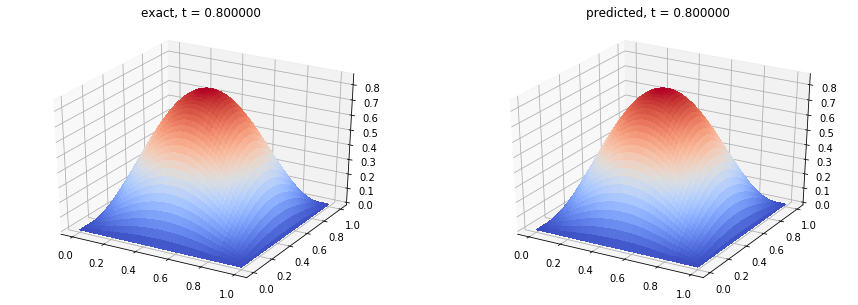

L2 error:  0.03487941839598552


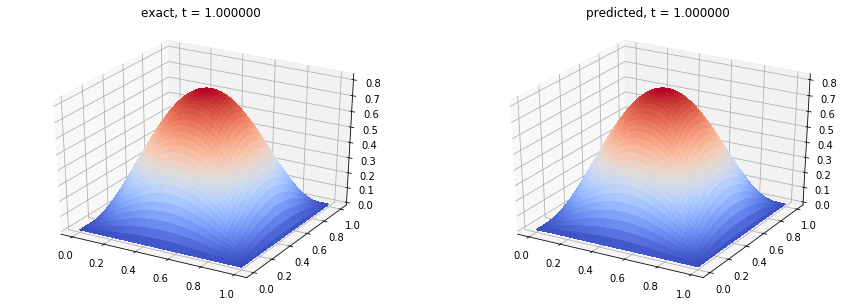

L2 error:  0.028861107282871504


In [12]:
# evaluate
from mpl_toolkits.mplot3d import Axes3D

x = np.linspace(0,1,100)
y = np.linspace(0,1,100)
t = np.array([0,0.2,0.4,0.6,0.8,1])

for t1 in t:

    eval_mesh=Mesh({'x': x,'y': y, 't':t1}, device=device)

    u=pde.eval(eval_mesh)
    u=u.cpu().numpy()
    
    _x, _y=np.meshgrid(x,y)
    u0=np.sin(np.pi*_x)*np.sin(np.pi*_y)*(np.exp(-0.02*np.pi*np.pi*t1))

    fig=plt.figure(figsize=(15, 5))
    ax1=fig.add_subplot(1,2,1,projection='3d')
    ax2=fig.add_subplot(1,2,2,projection='3d')
    ax1.plot_surface(_x, _y, u0.reshape((len(_y),len(_x))), cmap=cm.coolwarm, 
                     linewidth=0, antialiased=False)
    ax1.title.set_text('exact, t = %f' % t1)
    ax2.plot_surface(_x, _y, u.reshape((len(_y),len(_x))), cmap=cm.coolwarm, 
                     linewidth=0, antialiased=False)
    ax2.title.set_text('predicted, t = %f' % t1)
    plt.show()
    print("L2 error: ", np.sqrt(sum((u0.ravel()-u.ravel())**2)))